In [41]:
# !pip install transformers evaluate sentencepiece accelerate
# !pip install -U datasets

In [42]:
from collections import defaultdict, Counter
import json
import numpy as np
import torch

from matplotlib import pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader

In [43]:
train_data = load_dataset('csv',data_files = "train.csv")
val_data = load_dataset('csv',data_files="validation.csv")

In [44]:
def df_preprocess(dataset):
    df = dataset['train'].to_pandas()
    df = df[['joke', 'target']]
    # merge same category between cased/uncased
    df['target'] = df['target'].str.lower()
    # # select only jokes
    # df = df[df['target'] != 'not a joke']
    # uncase jokes to use uncased pretrained model
    df['joke'] = df['joke'].str.lower()
    df = df.rename(columns={'joke': 'text', 'target': 'labels'})
    # Drop rows where 'labels' is None
    df = df.dropna(subset=['labels'])
    return df

train_df = df_preprocess(train_data)
val_df = df_preprocess(val_data)

In [45]:
train_df.iloc[:,1].unique()

array(['body image', 'disability/health', 'not a joke', 'none',
       'sexual orientation', 'religious beliefs',
       'ethnicity/national origin', 'gender', 'other',
       'political beliefs', 'education'], dtype=object)

In [46]:
# filter only on common labels for training / validation
train_labels = set(train_df['labels'].unique())
val_labels = set(val_df['labels'].unique())

common_labels = list(train_labels.intersection(val_labels))
train_df_filtered = train_df[train_df['labels'].isin(common_labels)].copy()
val_df = val_df[val_df['labels'].isin(common_labels)].copy()


# Undersample the filtered training data
sampling_threshold = 112

final_train_df = (
    train_df_filtered.groupby('labels', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), sampling_threshold), random_state=42))
)
final_train_df = final_train_df.sample(frac=1, random_state=42).reset_index(drop=True)


# # --- FINAL VERIFICATION ---
# # Let's check the new label distribution to confirm it worked.
# # All counts should now be 30 or less.
# print("\n--- New Training Set Label Counts after Undersampling ---")
# print(final_train_df['labels'].value_counts())
# print(f"\nTotal size of the new, balanced training DataFrame: {len(final_train_df)}")

train_df = final_train_df

/tmp/ipython-input-3312234541.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), sampling_threshold), random_state=42))


labels
gender                       112
sexual orientation           112
religious beliefs            112
body image                   112
disability/health            112
political beliefs            112
none                         112
not a joke                   112
ethnicity/national origin    112
other                         24
education                     16
Name: count, dtype: int64


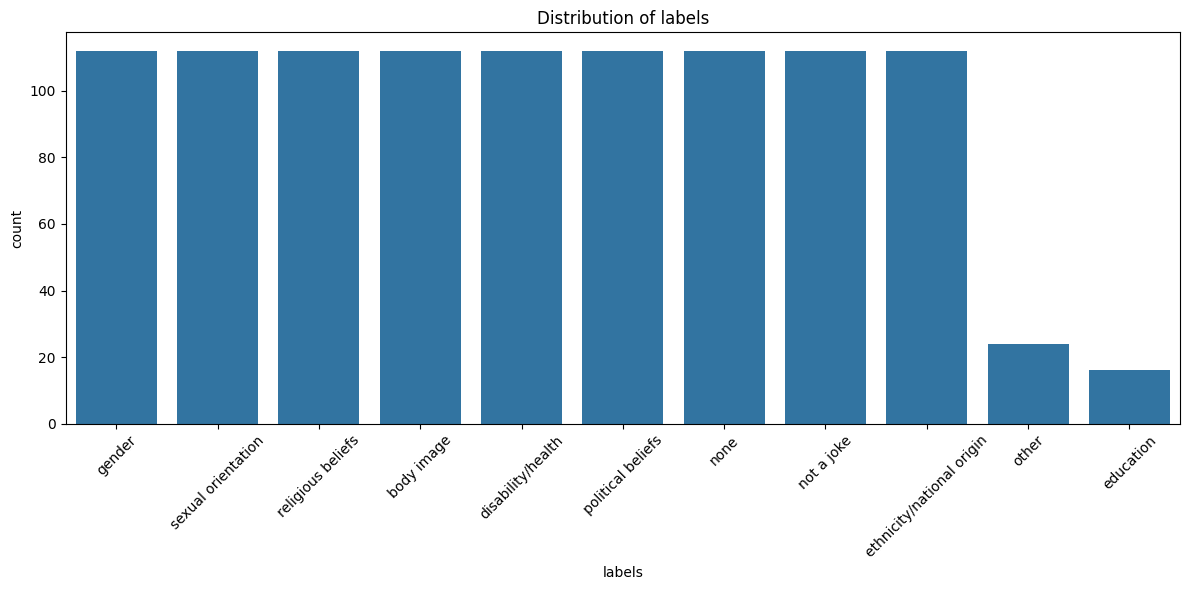

In [47]:
categorical_cols = ['labels']
for col in categorical_cols:
    print(train_df[col].value_counts())
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [48]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [49]:
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification,ElectraTokenizer,ElectraForSequenceClassification

name = "microsoft/deberta-v3-base"
# name = "distilbert/distilbert-base-uncased"
# name = "google/electra-base-discriminator"
# name = "FacebookAI/roberta-base"

tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=10)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

token_lengths = [len(tokenizer.encode(text)) for text in train_dataset['text']]
int(np.percentile(token_lengths, 95))
#set maxlength as 40(multiple of 8)

40

In [51]:
# Now that our tokenizer has been properly loaded, we need to call the tokenizer
# for every example in the dataset. Here we use list comprehension with a
# lambda function ensure that.

tokenized_train_dataset = train_dataset.map(
    lambda example: tokenizer(example['text'], padding="max_length",
    truncation=True, max_length=40)
)

tokenized_val_dataset = val_dataset.map(
    lambda example: tokenizer(example['text'], padding="max_length",
    truncation=True, max_length=40)
)

# We need to remove these extra columns before the dataset can be sent to the
# dataloader and subsequently to the model. Also be sure to check that the
# output column is named labels or else rename if necessary
tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text'])
tokenized_train_dataset.set_format("torch")

tokenized_val_dataset = tokenized_val_dataset.remove_columns(['text'])
tokenized_val_dataset.set_format("torch")

Map:   0%|          | 0/1048 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [52]:
# from transformers import get_linear_schedule_with_warmup
# from tqdm.notebook import tqdm
# from transformers import set_seed
# from torch.optim import AdamW
# import torch
# from sklearn.preprocessing import LabelEncoder
# import torch.nn as nn
# import os

# train_dataset = tokenized_train_dataset.shuffle(seed=1111).select(range(636))
# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=8,
#     shuffle=True
# )

# eval_dataset = tokenized_val_dataset.shuffle(seed=1111).select(range(512))
# eval_dataloader = DataLoader(
#     eval_dataset,
#     batch_size=8,
#     shuffle=False
# )

# set_seed(42)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_path = "model_checkpoint/"

# # Create the model checkpoint directory if it doesn't exist
# if not os.path.exists(model_path):
#     os.makedirs(model_path)

# # Create a label encoder
# le = LabelEncoder()
# # Fit the encoder on the training labels to learn all unique labels
# le.fit(train_df['labels'])

# # # Load the model configuration and model
# # config = AutoModelForSequenceClassification.from_pretrained(name).config
# # config.num_labels = len(le.classes_) # Set num_labels to the number of unique classes
# # print(len(le.classes_))
# # model = AutoModelForSequenceClassification.from_pretrained(name, config=config).to(device)
# model = model.to(device)

# num_epochs = 8
# num_training_steps = len(train_dataloader) * num_epochs

# optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
# # optimizer = AdamW(model.parameters(), lr=10e-5, weight_decay=0.02)

# # !pip install bitsandbytes
# # from bitsandbytes.optim import Lion
# # # Define Lion optimizer with adjusted LR and weight decay
# # lion_lr = 1e-5         # 5e-5 (AdamW) ÷ 5
# # lion_wd = 0.05         # 0.01 (AdamW) × 5

# # optimizer = Lion(
# #     params=model.parameters(),
# #     lr=lion_lr,
# #     betas=(0.9, 0.99),
# #     weight_decay=lion_wd
# # )

# lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# # Define the loss function
# loss_fct = nn.CrossEntropyLoss()

# best_val_loss = float("inf")
# for epoch in range(num_epochs):
#     # training
#     model.train()
#     training_losses = []
#     for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):

#         optimizer.zero_grad()

#         # copy input to device
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         # Encode labels to numerical IDs and convert to tensor before moving to device
#         labels = torch.tensor(le.transform(batch['labels'])).to(device)


#         # Call the model for Forward Pass
#         output = model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#         )
#         logits = output.logits
#         training_loss = loss_fct(logits, labels)
#         training_losses.append(training_loss.item())

#         #Do backprop and update params by taking an optimization step
#         training_loss.backward()
#         optimizer.step()
#         lr_scheduler.step()

#     print("Mean Training Loss", np.mean(training_losses))

#     # validation
#     val_loss = 0
#     #set to evaluation mode because we dont want to collect gradients
#     model.eval()
#     for batch_i, batch in enumerate(eval_dataloader):
#         with torch.no_grad():
#             # copy input to device
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             # Encode labels to numerical IDs and convert to tensor before moving to device
#             labels = torch.tensor(le.transform(batch['labels'])).to(device)


#             #call the model again for Forward Pass
#             output = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#             )
#             logits = output.logits
#             val_loss += loss_fct(logits, labels)

#     # calculating average validation loss across all batches
#     avg_val_loss = val_loss / len(eval_dataloader)
#     print(f"Validation loss: {avg_val_loss}")

#     # Saving this model checkpoint only if the current validation loss
#     # is better than the best validation loss obtained so far
#     if avg_val_loss < best_val_loss:
#         print("Saving checkpoint!")
#         best_val_loss = avg_val_loss
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'val_loss': best_val_loss,
#             },
#             f"{model_path}epoch_{epoch}.pt"
#         )
#     print()

# print(f"The best validation loss after {num_epochs} epochs is: {best_val_loss}")

In [53]:
import warnings
# This will ignore any warning that contains the specified text
warnings.filterwarnings('ignore', message='.*encoder_attention_mask.*')

In [54]:
# Grid Search

import pandas as pd
from sklearn.model_selection import ParameterGrid
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from transformers import set_seed
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import numpy as np
import os

# # --- STEP 1: DEFINE THE HYPERPARAMETER GRID ---
# param_grid = {
#     'learning_rate': [5e-5, 3e-5, 1e-5],
#     'weight_decay': [0.01, 0.05, 0.1],
#     'batch_size': [2,4,8,16,32]
# }

param_grid = {
    'learning_rate': [1e-5],
    'weight_decay': [0.1],
    'batch_size': [8]
}

grid = ParameterGrid(param_grid)

# --- STEP 2: PREPARE FOR THE SEARCH ---
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "model_checkpoint/"

if not os.path.exists(model_path):
    os.makedirs(model_path)

# Create a label encoder ONCE before the loop
le = LabelEncoder()
# ensured train/val have same labels
le.fit(train_df['labels'])

num_epochs = 8 # Use fewer epochs for grid search to save time, can increase for final model
results = []
best_overall_val_loss = float("inf")

# --- STEP 3: RUN THE GRID SEARCH LOOP ---
print(f"Starting grid search for {len(grid)} combinations...")

for i, params in enumerate(grid):
    print("-" * 50)
    print(f"Combination {i+1}/{len(grid)}")
    print(f"Parameters: {params}")
    print("-" * 50)

    # batch size
    current_batch_size = params['batch_size']
    train_dataloader = DataLoader(
        tokenized_train_dataset,
        batch_size=current_batch_size,
        shuffle=True
    )
    eval_dataloader = DataLoader(
        tokenized_val_dataset,
        batch_size=current_batch_size,
        shuffle=False
    )

    # config
    config = AutoModelForSequenceClassification.from_pretrained(name).config
    config.num_labels = len(le.classes_)
    model = AutoModelForSequenceClassification.from_pretrained(name, config=config).to(device)

    # lr and weight decay
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    num_training_steps = len(train_dataloader) * num_epochs
    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    loss_fct = nn.CrossEntropyLoss()

    best_run_val_loss = float("inf")
    best_model_for_run_path = f"{model_path}run_{i}_best.pt"
    for epoch in range(num_epochs):
        # Training
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = torch.tensor(le.transform(batch['labels'])).to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = output.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in eval_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = torch.tensor(le.transform(batch['labels'])).to(device)

                output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += output.loss.item()

        avg_val_loss = total_val_loss / len(eval_dataloader)
        print(f"Epoch {epoch+1}: Validation Loss = {avg_val_loss:.4f}")

        # Track the best validation loss for this specific run
        if avg_val_loss < best_run_val_loss:
            print(f"Validation loss improved. Saving checkpoint for this run to {best_model_for_run_path}")
            best_run_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_for_run_path) # Save the *current* model state

    # --- Store the results for this combination ---
    run_result = params.copy()
    run_result['validation_loss'] = best_run_val_loss
    results.append(run_result)

    # save the best model found so far across all runs
    if best_run_val_loss < best_overall_val_loss:
        print(f"\nNew best overall model found! Saving to best_model.pt\n")
        best_overall_val_loss = best_run_val_loss
        # load the state we saved earlier for this specific run
        best_model_state = torch.load(best_model_for_run_path)
        torch.save(best_model_state, "best_overall_model.pt")

# --- STEP 4: ANALYZE THE RESULTS ---
print("\n" + "="*50)
print("Grid Search Complete!")
print("="*50)

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='validation_loss', ascending=True)

print("Grid Search Results:")
print(results_df)

print("\nBest Hyperparameters:")
print(results_df.iloc[0])

Starting grid search for 1 combinations...
--------------------------------------------------
Combination 1/1
Parameters: {'batch_size': 8, 'learning_rate': 1e-05, 'weight_decay': 0.1}
--------------------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1: Validation Loss = 2.2728
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 2 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2: Validation Loss = 1.8577
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 3 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3: Validation Loss = 1.6298
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 4 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4: Validation Loss = 1.5288
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 5 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5: Validation Loss = 1.4993
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 6 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6: Validation Loss = 1.4537
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 7 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7: Validation Loss = 1.4170
Validation loss improved. Saving checkpoint for this run to model_checkpoint/run_0_best.pt


Epoch 8 Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8: Validation Loss = 1.4427

New best overall model found! Saving to best_model.pt


Grid Search Complete!
Grid Search Results:
   batch_size  learning_rate  weight_decay  validation_loss
0           8        0.00001           0.1         1.416986

Best Hyperparameters:
batch_size         8.000000
learning_rate      0.000010
weight_decay       0.100000
validation_loss    1.416986
Name: 0, dtype: float64


In [55]:
# from sklearn.metrics import accuracy_score, f1_score
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.eval()
# test_batch_logits = []
# y_true = []
# for batch_i, batch in enumerate(eval_dataloader):
#     with torch.no_grad():
#         # copy input to device
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         # Encode labels to numerical IDs and convert to tensor before moving to device
#         labels = torch.tensor(le.transform(batch['labels'])).to(device)
#         y_true.extend(labels.cpu().detach().numpy())

#         # Call the model on test data
#         output = model(input_ids=input_ids, attention_mask=attention_mask)
#         test_batch_logits.append(output.logits)


from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch

# --- STEP 1: LOAD THE BEST MODEL ---
print("Loading the best model for evaluation...")

# Define the path to your saved model
best_model_path = "best_overall_model.pt"

# You must first instantiate a model with the same architecture as the one you saved.
# Ensure the 'name' variable (e.g., "bert-base-uncased") and 'le' (LabelEncoder) are available.
config = AutoModelForSequenceClassification.from_pretrained(name).config
config.num_labels = len(le.classes_)

# Create the model instance
model_for_eval = AutoModelForSequenceClassification.from_pretrained(name, config=config)

# Load the saved weights (the state_dict) into the model
model_for_eval.load_state_dict(torch.load(best_model_path))

# Move the model to the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_for_eval.to(device)

# --- STEP 2: RUN EVALUATION USING THE LOADED MODEL ---
print("Starting evaluation...")
model_for_eval.eval()  # Set the model to evaluation mode

y_true = []
test_logits = []

# Use the same eval_dataloader from your grid search
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        # Copy input to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Store the true labels
        labels = le.transform(batch['labels'])
        y_true.extend(labels)

        # Call the loaded model on the data
        output = model_for_eval(input_ids=input_ids, attention_mask=attention_mask)
        test_logits.append(output.logits.cpu()) # Move logits to CPU to save GPU memory

# --- STEP 3: CALCULATE AND DISPLAY METRICS ---
print("Calculating metrics...")

# Concatenate logits from all batches and get the predicted labels
all_logits = torch.cat(test_logits, dim=0)
y_pred = torch.argmax(all_logits, dim=1).numpy()

# Sanity check: should have as many predictions as labels
assert len(y_pred) == len(y_true)

# Call the f1_score function
print('\nF1 Score (Macro):', f1_score(y_true, y_pred, average='macro'))

# Call the accuracy_score function
print('Accuracy Score:', accuracy_score(y_true, y_pred))

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Loading the best model for evaluation...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting evaluation...


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Calculating metrics...

F1 Score (Macro): 0.4844665758351249
Accuracy Score: 0.6052173913043478

Classification Report:
                           precision    recall  f1-score   support

               body image       0.46      0.64      0.53        25
        disability/health       0.47      0.67      0.55        39
                education       0.00      0.00      0.00         6
ethnicity/national origin       0.69      0.59      0.64        91
                   gender       0.48      0.54      0.51        41
                     none       0.56      0.41      0.47        97
               not a joke       0.83      0.74      0.78       107
                    other       0.00      0.00      0.00         7
        political beliefs       0.53      0.60      0.56        62
        religious beliefs       0.64      0.78      0.70        67
       sexual orientation       0.51      0.67      0.58        33

                 accuracy                           0.61       575
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
